In [1]:
### Install necessary libraries
library(NLP)
library(slam)
library(tm)
library(SnowballC)
library(wordcloud)
library(fpc)
library(rlang)
library(ggplot2)

Loading required package: RColorBrewer

Attaching package: 'ggplot2'

The following object is masked from 'package:NLP':

    annotate



In [2]:
file_loc <- "C:/Users/tfost/Desktop/Data/Text Analysis/Amazon Reviews/pressure.csv"
reviews <- read.csv(file_loc, header = TRUE)

In [3]:
colnames(reviews)

[1] "X"       "author"  "body"    "date"    "helpful" "rating"  "title"




# **Corpus** - Corpora are collections of documents containing (natural language) text

***

In [4]:
# To create the corpus
# First column must be named "doc_id"
# Second column must be named "text"
reviews <- reviews[,c(1,3,2,4:7)]
colnames(reviews)[1] <- "doc_id"
colnames(reviews)[2] <- "text"

In [5]:
# Change ratings from factor to numeric value
reviews$rating <- as.numeric(substr(as.character(reviews$rating),3,3))
# Break the reviews into low- and high-rated groups
low_reviews <- subset(reviews, rating < 4, 
                      select=c(doc_id, text))
hi_reviews <- subset(reviews, rating > 3, 
                     select=c(doc_id, text))

In [6]:
low_corp <- Corpus(VectorSource(low_reviews$text))
hi_corp <- Corpus(VectorSource(hi_reviews$text))
### Data preprocessing

inspect(low_corp[[7]])

<<PlainTextDocument>>
Metadata:  7
Content:  chars: 529

['I have used this product for one thing only, cooking beans and on the sixth (6) time I used it it would not heat up. No matter what I do it does not work. I contacted the manufacture and they want me to pay 25 bones to ship it to them to see if it can be repaired and another 25 dollars to ship it back to me.. Why would I do that for a defective piece of equipment?? 60 day warranty on defects, You should run, shame on me for not researching this first..', '4 Star when it worked', '2 Star on your warranty on workmanship..']


In [7]:
inspect(hi_corp[[7]])

<<PlainTextDocument>>
Metadata:  7
Content:  chars: 185

['Very satisfied with my power pressure cooker,will be using it quite a lot.', "Love how it turns itself off when done,don't have to worry about running to see", 'if the food is done.']


# **Text Cleansing and Normalization** - The process of removing unnecessary elements in the text and ensuring consistency across the corpus.

## -  Removing invalid or special characters (^&>{)
## -  Removing white space
## -  Removing punctuation
## -  Removing numbers
## -  Convert all to lower case
## -  Remove stop words (is, to, the, a, etc.)
## -  Stemming - Changing words to their roots
### -  "waiting" to "wait"
### -  "cleaned" to "clean"
### -  "warranty" to "warranti"

***


In [8]:
# Remove invalid characters
removeInvalid<-function(x) gsub("[^\x01-\x7F]", "", x)
low_corp <- tm_map(low_corp, content_transformer(removeInvalid))
hi_corp <- tm_map(hi_corp, content_transformer(removeInvalid))
inspect(low_corp[[7]])

<<PlainTextDocument>>
Metadata:  7
Content:  chars: 529

['I have used this product for one thing only, cooking beans and on the sixth (6) time I used it it would not heat up. No matter what I do it does not work. I contacted the manufacture and they want me to pay 25 bones to ship it to them to see if it can be repaired and another 25 dollars to ship it back to me.. Why would I do that for a defective piece of equipment?? 60 day warranty on defects, You should run, shame on me for not researching this first..', '4 Star when it worked', '2 Star on your warranty on workmanship..']


In [12]:
# Remove special characters individually
toSpace <- content_transformer(function (x , pattern ) gsub(pattern, " ", x))
low_corp <- tm_map(low_corp, toSpace, "@")
hi_corp <- tm_map(hi_corp, toSpace, "@")

In [9]:
# Remove whitespace
low_corp <- tm_map(low_corp, stripWhitespace)
hi_corp <- tm_map(hi_corp, stripWhitespace)
inspect(low_corp[[7]])

<<PlainTextDocument>>
Metadata:  7
Content:  chars: 529

['I have used this product for one thing only, cooking beans and on the sixth (6) time I used it it would not heat up. No matter what I do it does not work. I contacted the manufacture and they want me to pay 25 bones to ship it to them to see if it can be repaired and another 25 dollars to ship it back to me.. Why would I do that for a defective piece of equipment?? 60 day warranty on defects, You should run, shame on me for not researching this first..', '4 Star when it worked', '2 Star on your warranty on workmanship..']


In [10]:
# Remove punctuation
low_corp <- tm_map(low_corp, removePunctuation)
hi_corp <- tm_map(hi_corp, removePunctuation)
inspect(low_corp[[7]])

<<PlainTextDocument>>
Metadata:  7
Content:  chars: 504

I have used this product for one thing only cooking beans and on the sixth 6 time I used it it would not heat up No matter what I do it does not work I contacted the manufacture and they want me to pay 25 bones to ship it to them to see if it can be repaired and another 25 dollars to ship it back to me Why would I do that for a defective piece of equipment 60 day warranty on defects You should run shame on me for not researching this first 4 Star when it worked 2 Star on your warranty on workmanship


In [11]:
# Remove numbers
# I decided not to do this.  Shown here FYI.
# low_corp <- tm_map(low_corp, removeNumbers)

In [13]:
#Convert to lower case
low_corp <- tm_map(low_corp, tolower)
hi_corp <- tm_map(hi_corp, tolower)
inspect(low_corp[[7]])

<<PlainTextDocument>>
Metadata:  7
Content:  chars: 504

i have used this product for one thing only cooking beans and on the sixth 6 time i used it it would not heat up no matter what i do it does not work i contacted the manufacture and they want me to pay 25 bones to ship it to them to see if it can be repaired and another 25 dollars to ship it back to me why would i do that for a defective piece of equipment 60 day warranty on defects you should run shame on me for not researching this first 4 star when it worked 2 star on your warranty on workmanship


In [14]:
#Remove stop words
low_corp <- tm_map(low_corp, removeWords, stopwords("english"))
hi_corp <- tm_map(hi_corp, removeWords, stopwords("english"))
inspect(low_corp[[7]])

<<PlainTextDocument>>
Metadata:  7
Content:  chars: 343

  used  product  one thing  cooking beans    sixth 6 time  used     heat   matter       work  contacted  manufacture   want   pay 25 bones  ship     see   can  repaired  another 25 dollars  ship  back          defective piece  equipment 60 day warranty  defects   run shame     researching  first 4 star   worked 2 star   warranty  workmanship


In [15]:
# SMART is another stopwords dictionary
# low_corp <- tm_map(low_corp, removeWords, stopwords("SMART"))

In [16]:
# Stemming
low_corp <- tm_map(low_corp, stemDocument)
hi_corp <- tm_map(hi_corp, stemDocument)
inspect(low_corp[[7]])

<<PlainTextDocument>>
Metadata:  7
Content:  chars: 253

use product one thing cook bean sixth 6 time use heat matter work contact manufactur want pay 25 bone ship see can repair anoth 25 dollar ship back defect piec equip 60 day warranti defect run shame research first 4 star work 2 star warranti workmanship


# **Bag of Words (BoW)** 
## -  Looks at frequency of word occurrence 
## -  Ignores context and sentence structure

***

# **<font color=blue>Document-Term Matrix<font>
## <font color=blue>- A matrix that lists each document as a row and each term as a column<font>
## <font color=blue>- A Term-Document Matrix reverses those two roles<font>

***

# **<font color=green>Sparsity<font>**
## <font color=green>- Percentage of cells with a "0" entry.<font>
    
***

In [17]:
### Term frequencies

#Build the Document term matrices
dtm_low <- DocumentTermMatrix(low_corp)
dtm_low
freq_low <- colSums(as.matrix(dtm_low))   
freq_low

<<DocumentTermMatrix (documents: 754, terms: 3054)>>
Non-/sparse entries: 24473/2278243
Sparsity           : 99%
Maximal term length: 136
Weighting          : term frequency (tf)

addit 
                                                                                                                                      20 
                                                                                                                                     ago 
                                                                                                                                      26 
                                                                                                                                aluminum 
                                                                                                                                      16 
                                                                                                                                   alway 
                                                                                                                                      26 
                                                                                                                                  appear 
                                                                                                                                      14 
                                                                                                                                     ask 
                                                                                                                                      33 
                                                                                                                                     bad 
                                                                                                                                      42 
                                                                                                                                    bodi 
                                                                                                                                       2 
                                                                                                                                  bought 
                                                                                                                                     147 
                                                                                                                                    burn 
                                                                                                                                      56 
                                                                                                                                  button 
                                                                                                                                      49 
                                                                                                                                   claim 
                                                                                                                                      17 
                                                                                                                                   clear 
                                                                                                                                      21 
                                                                                                                                    coat 
                                                                                                                                      53 
                                                                                                                                    come 
                                                                                                                                 

In [18]:
dtm_hi <- DocumentTermMatrix(hi_corp)
dtm_hi
freq_hi <- colSums(as.matrix(dtm_hi))   
freq_hi

<<DocumentTermMatrix (documents: 1496, terms: 3051)>>
Non-/sparse entries: 27049/4537247
Sparsity           : 99%
Maximal term length: 25
Weighting          : term frequency (tf)

2lb                    adjust                     admit 
                        1                        18                         7 
                      air                     allow                      alon 
                        3                        10                         8 
                  alreadi                      amaz                    amazon 
                       30                        90                        60 
                      ask                    awesom                      back 
                        6                        77                        43 
                     bath                       bbb                       bed 
                        7                         2                         4 
                     beef                     begin                    better 
                       71                        10                        72 
                   beyond                      bird                      bone 
                        5                         1                        34 
                  booklet                    bought                     brown 
                       11                       164                        54 
                   button                       buy                      call 
                       53                       100                        27 
                     came                       can                    cancel 
                       85                       312                         5 
                  canning                     chees                   chicken 
                      120                        16                       184 
              chickenmeat                     chuck                     clean 
                       14                         6                       131 
                     come                  commerci                   compani 
                      136                         7                        16 
                complaint                   complet                      cook 
                       16                        21                       931 
                 cookbook                    cooker                     coupl 
                       48                       762                        22 
                      cup                    custom                       cut 
                       29                        18                        46 
                     cycl                     decid                      deep 
                       13                        25                         5 
                    didnt                       die                     dijon 
                       63                         5                         1 
                   direct                     eager                   earlier 
                       54                         1                         6 
                     easi                  elsewher                       end 
                      247                         2                        18 
                    error                   essenti                      even 
                       10                         2                        88 
                   expens                     extra                       eye 
                        9                        19                         3 
                      far                    featur                  feedback 
                      108                        33                         4 
                     fell                      fill                     final 
                        7                        12                        17 
                    first                    flavor                    follow 
                      132                        57                        41 
                     food                      full                    g

In [19]:
#Number of distinct terms in all documents
length(freq_low)   
terms_low <- as.matrix(dtm_low)   
dim(terms_low)   
terms_low

[1] 3054

[1]  754 3054

,addit,ago,aluminum,alway,appear,ask,bad,bodi,bought,burn,...,unbeknownst,wood,ladi,thi,whould,yard,california,unhealthi,furnish,flop
1,1,2,2,1,1,1,1,1,1,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,1,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [20]:
length(freq_hi)   
terms_hi <- as.matrix(dtm_hi)   
dim(terms_hi)  
terms_hi

[1] 3051

[1] 1496 3051

,2lb,adjust,admit,air,allow,alon,alreadi,amaz,amazon,ask,...,purchaseeven,brother,brotherinlaw,inlaw,spud,bbcco,wayn,wkozak221gmailcom,itdont,passif
1,1,1,2,1,1,1,1,1,3,1,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
6,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
7,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
8,0,0,0,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
9,0,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [21]:
#List the terms that appear at least 100 or 200 times
findFreqTerms(dtm_low, lowfreq=100)


[1] "bought"   "come"     "cook"     "cooker"   "day"      "dont"    
 [7] "food"     "get"      "good"     "got"      "lid"      "month"   
[13] "now"      "one"      "pot"      "pressur"  "tri"      "use"     
[19] "well"     "will"     "work"     "buy"      "call"     "clean"   
[25] "custom"   "even"     "replac"   "time"     "just"     "product" 
[31] "return"   "back"     "can"      "purchas"  "first"    "thing"   
[37] "warranti" "like"     "take"     "make"     "unit"     "minut"   
[43] "servic"   "power"    "instruct" "recip"

In [22]:
findFreqTerms(dtm_hi, lowfreq=200)

[1] "can"     "cook"    "cooker"  "easi"    "get"     "just"    "like"   
 [8] "love"    "make"    "minut"   "one"     "pot"     "pressur" "product"
[15] "recip"   "thing"   "time"    "use"     "work"    "great"   "meal"

In [23]:
# Find Words Associations
# corlimit is the chance the two words appear in the same document
findAssocs(dtm_low, 
           c("cook", "clean", "dont", "product", "warranti", "servic", 
             "instruct", "power", "lid", "return")
           , corlimit=0.40)


$cook
   time pressur 
    0.5     0.4 

$clean
   pot bottom 
  0.43   0.43 

$dont
    cent  curtesi individu  misplac 
    0.51     0.51     0.51     0.51 

$product
purchas 
   0.41 

$warranti
             06495               2the              3this            4repair 
              0.80               0.80               0.80               0.80 
             appli             breach        consequenti             exclus 
              0.80               0.80               0.80               0.80 
           feasibl           incident           institut              legal 
              0.80               0.80               0.80               0.80 
             liabl              modif               road              shall 
              0.80               0.80               0.80               0.80 
           subject          theexclus           unauthor              valid 
              0.80               0.80               0.80               0.80 
              void        wallingford warrantymanufactur              impli 
              0.80               0.80               0.80               0.76 
             limit              durat             consum             repair 
              0.73               0.71               0.62               0.59 
             misus               abus             compon                inc 
              0.59               0.59               0.56               0.56 
        particular           merchant            mainten              accid 
              0.56               0.56               0.56               0.56 
               500             remedi              proof        workmanship 
              0.56               0.56               0.54               0.51 
            postag              forth            warrant             defect 
              0.51               0.48               0.48               0.47 
          demonstr               tear              sixti              state 
              0.45               0.45               0.45               0.44 
          procedur              secur                day              cover 
              0.44               0.44               0.42               0.41 
            extend 
              0.40 

$servic
custom 
  0.88 

$instruct
numeric(0)

$power
cooker 
  0.42 

$lid
close  lock 
 0.45  0.45 

$return
numeric(0)

In [24]:
findAssocs(dtm_hi, 
           c("cook", "clean", "dont", "product", "warranti", "servic", 
             "instruct", "power", "lid", "return")
           , corlimit=0.40)

$cook
pressur    time  cooker     can     use     pot     get   minut     set    meat 
   0.72    0.65    0.58    0.55    0.54    0.52    0.50    0.50    0.49    0.48 
  steam    also  adjust   brown  button    slow  longer     low    just    make 
   0.46    0.43    0.42    0.42    0.42    0.42    0.42    0.42    0.41    0.41 
canning    even    test 
   0.40    0.40    0.40 

$clean
easi 
0.44 

$dont
            pain           consum             just            thing 
            0.49             0.45             0.44             0.44 
            know            accus           anyhoo            brain 
            0.43             0.43             0.43             0.43 
            card             cent              com           crappi 
            0.43             0.43             0.43             0.43 
             dot              ear          everest        everybodi 
            0.43             0.43             0.43             0.43 
            evil facebookpintrest         repackag            royal 
            0.43             0.43             0.43             0.43 
            sake             spit          therapi            theri 
            0.43             0.43             0.43             0.43 
         whoever           appeal          conclus         disclaim 
            0.43             0.43             0.43             0.43 
          dollar             fond            intro          percent 
            0.43             0.43             0.43             0.43 
           there             hiss            sound           gasket 
            0.43             0.41             0.41             0.40 

$product
   form tristar 
   0.42    0.40 

$warranti
     3yr  complex   couldv     goto   hazard overbear    plagu  popular 
     0.5      0.5      0.5      0.5      0.5      0.5      0.5      0.5 
 protect     rang    swift 
     0.5      0.5      0.5 

$servic
   custom     float      isol onlinefil      wors      wild 
     0.82      0.55      0.55      0.55      0.55      0.45 

$instruct
read 
 0.4 

$power
   bulki     entr flawless   necess     pair phenomen    teeth    uniqu 
    0.56     0.56     0.56     0.56     0.56     0.56     0.56     0.56 
   xa0th     cord     chop   cooker     ladl  pressur soupstew     pure 
    0.56     0.55     0.52     0.49     0.49     0.48     0.46     0.46 
  lentil selector    digit  chopper   measur    lunch     pork 
    0.46     0.46     0.45     0.44     0.44     0.43     0.42 

$lid
wash seal 
0.44 0.43 

$return
strike  third 
  0.60   0.45

In [25]:
findAssocs(dtm_hi, 
           c("easi", "great", "minut", "love", "meal")
           , corlimit=0.40)


$easi
clean 
 0.44 

$great
numeric(0)

$minut
          approxim          bottomlin             calibr             cherri 
              0.65               0.65               0.65               0.65 
           clarifi              dress                eve           explicit 
              0.65               0.65               0.65               0.65 
            freebi               henc             interv              phase 
              0.65               0.65               0.65               0.65 
pressurizationmeat           procedur             repost   reseasoningaddit 
              0.65               0.65               0.65               0.65 
         statement             suffic               util             wateri 
              0.65               0.65               0.65               0.65 
           complet            brisket              stage          repressur 
              0.63               0.61               0.59               0.59 
             honey              durat              veget              grill 
              0.57               0.57               0.55               0.54 
             first              stock               unit              total 
              0.53               0.52               0.52               0.51 
         afterward             outsid               cook               cycl 
              0.51               0.51               0.50               0.50 
             state              smoke              orang              place 
              0.50               0.50               0.50               0.49 
              meat              brais               took              drain 
              0.49               0.49               0.48               0.48 
         depressur               time         manufactur               cake 
              0.48               0.47               0.46               0.46 
            prepar              advic             remain           outstand 
              0.46               0.46               0.46               0.46 
            inform               term              minus            pressur 
              0.46               0.46               0.46               0.45 
              sear           previous             simmer                pot 
              0.44               0.43               0.43               0.42 
              done             season              pound             consid 
              0.42               0.41               0.41               0.41 

$love
numeric(0)

$meal
numeric(0)

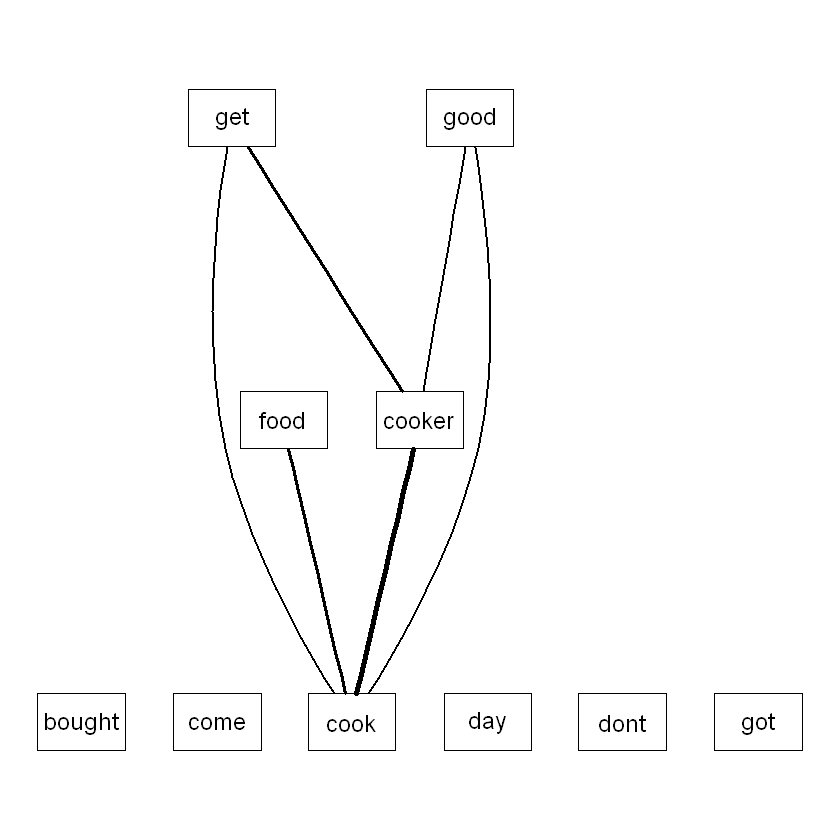

In [33]:
######### Correlation plot
# Run the next two lines once
# source("http://bioconductor.org/biocLite.R")
# biocLite("Rgraphviz")
par(mar=c(0,0,0,0))
plot(dtm_low, terms=findFreqTerms(dtm_low, lowfreq=100)[1:10], corThreshold=0.20, weighting = T)

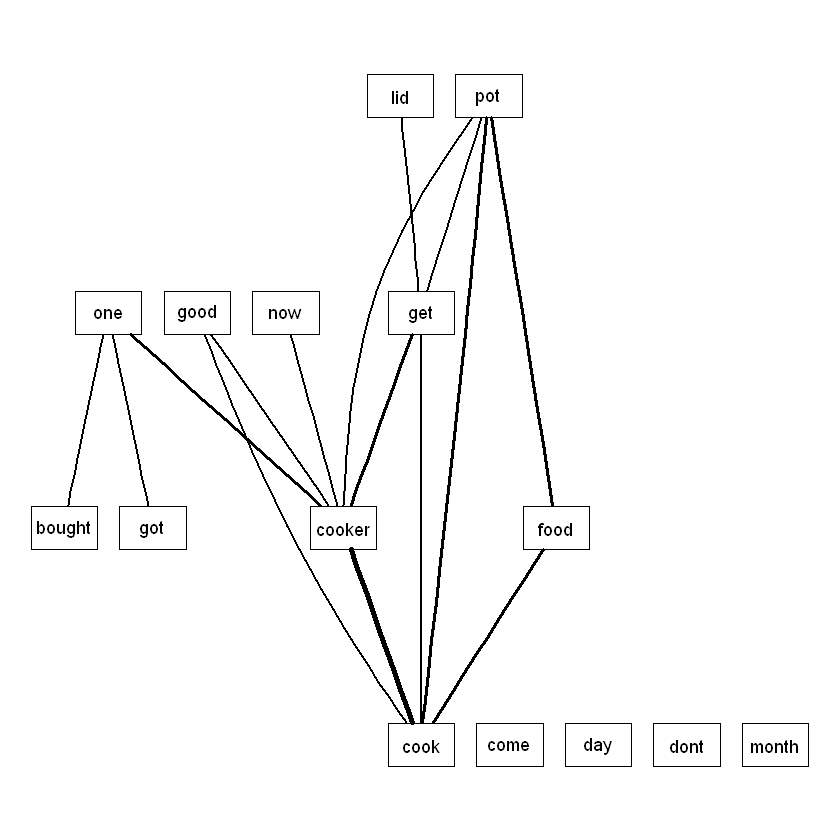

In [34]:
plot(dtm_low, terms=findFreqTerms(dtm_low, lowfreq=100)[1:15], corThreshold=0.20, weighting = T)

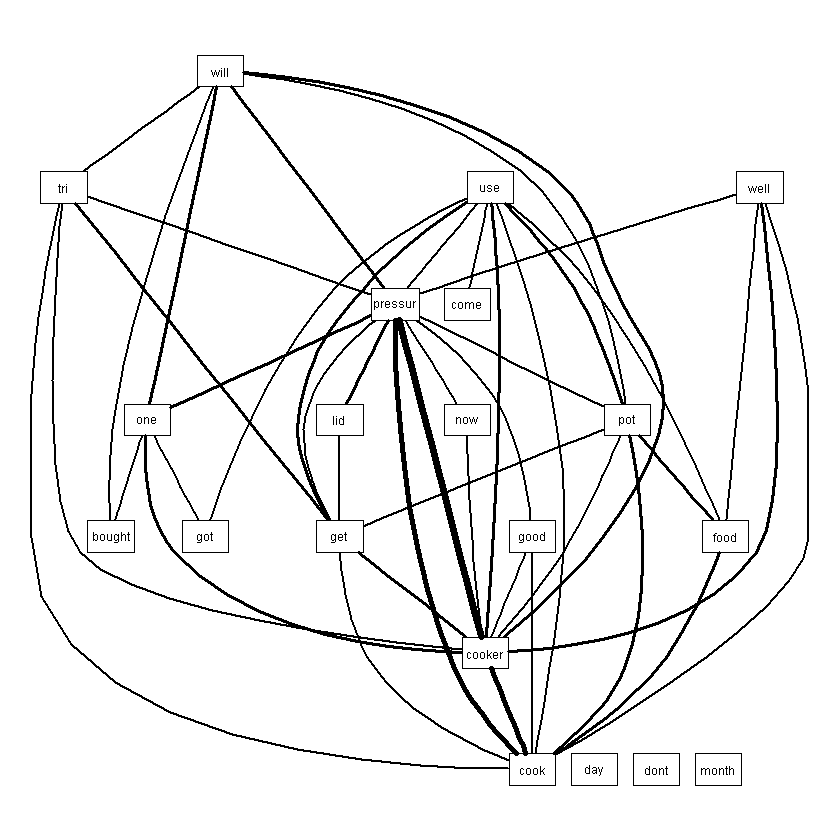

In [35]:
plot(dtm_low, terms=findFreqTerms(dtm_low, lowfreq=100)[1:20], corThreshold=0.20, weighting = T)

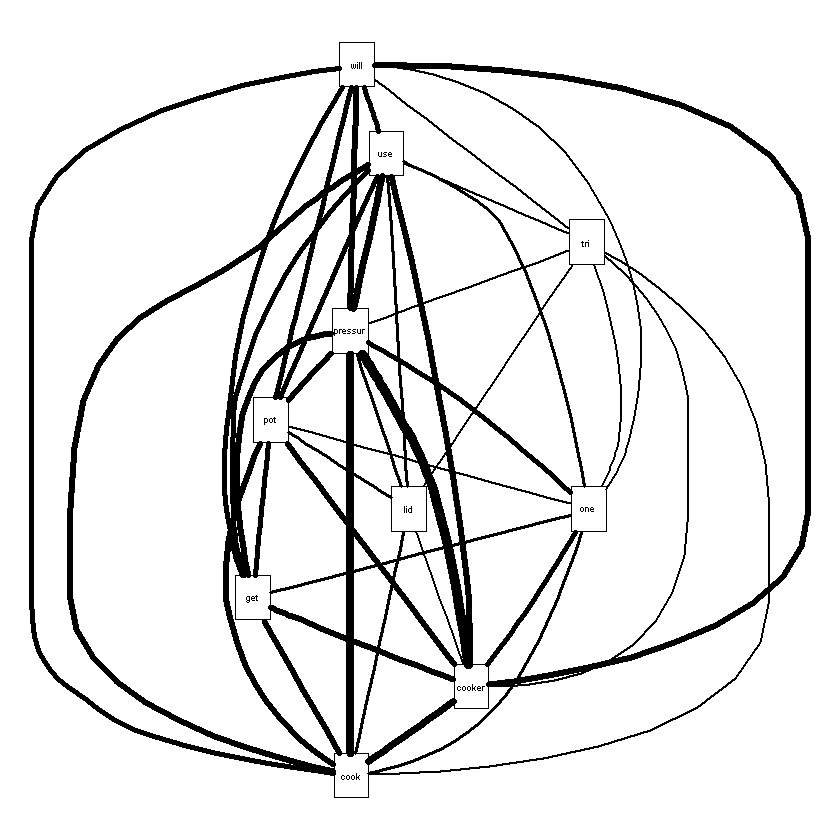

In [36]:
plot(dtm_hi, terms=findFreqTerms(dtm_low, lowfreq=200)[1:10], corThreshold=0.20, weighting = T)

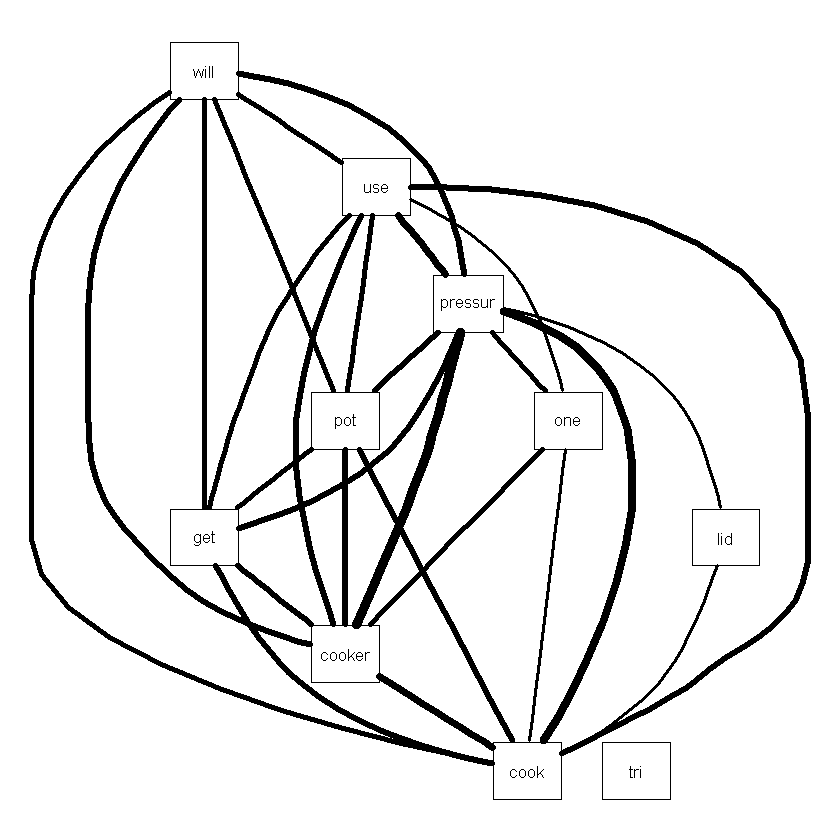

In [37]:
plot(dtm_hi, terms=findFreqTerms(dtm_low, lowfreq=200)[1:10], corThreshold=0.30, weighting = T)

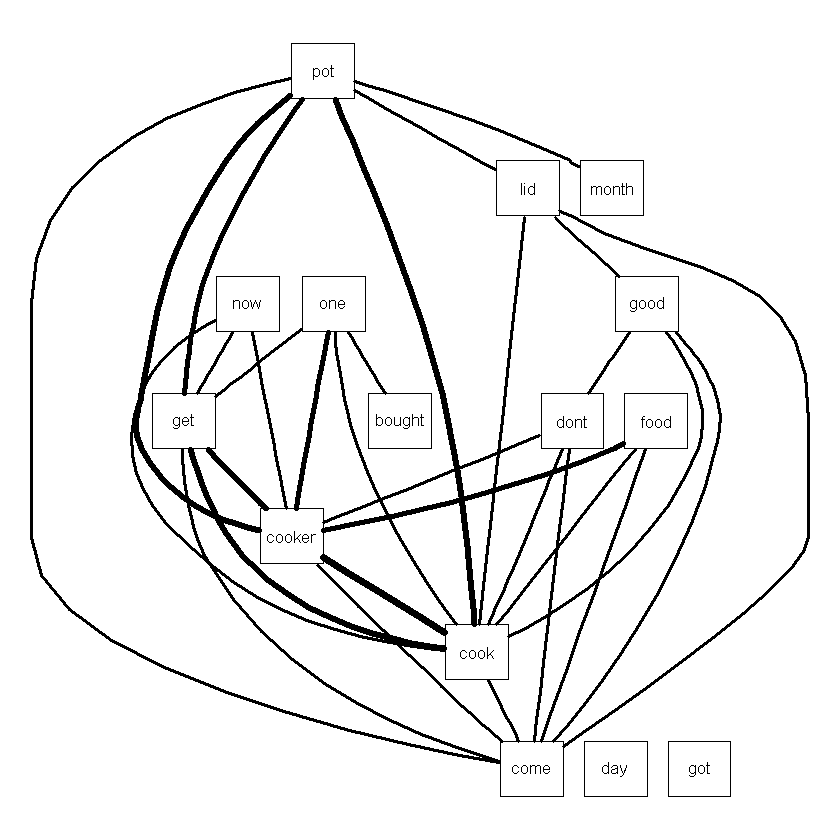

In [38]:
plot(dtm_hi, terms=findFreqTerms(dtm_low, lowfreq=100)[1:15], corThreshold=0.25, weighting = T)

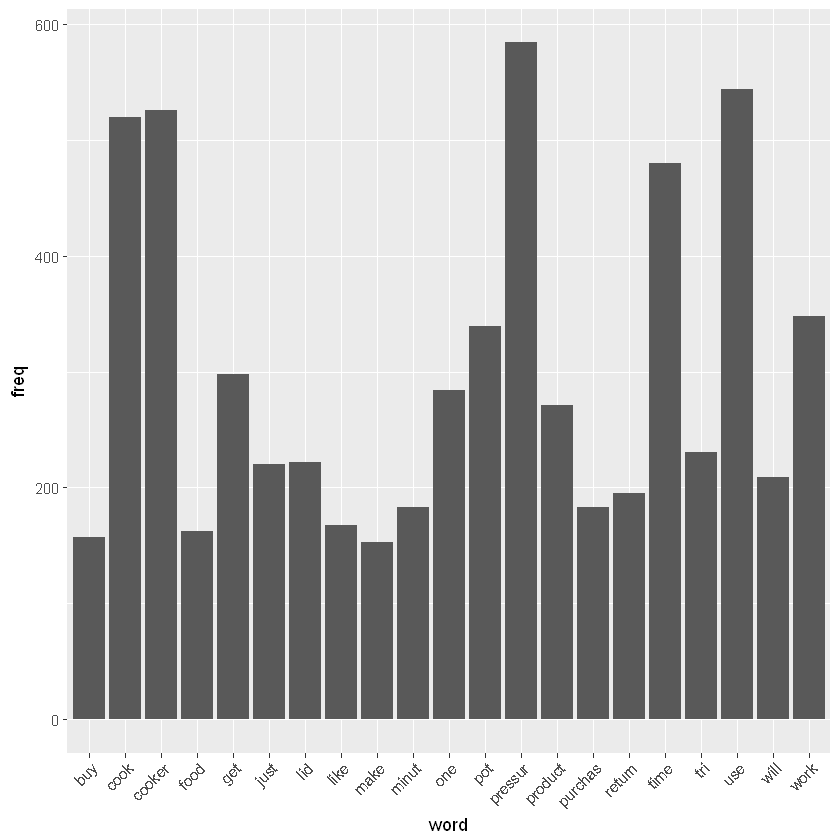

In [39]:
# Plot bar charts of frequent terms
wf <- data.frame(word=names(freq_low), freq=freq_low)
p <- ggplot(subset(wf, freq>150), aes(word, freq))
p <- p + geom_bar(stat="identity")
p <- p + theme(axis.text.x=element_text(angle=45, hjust=1))
p

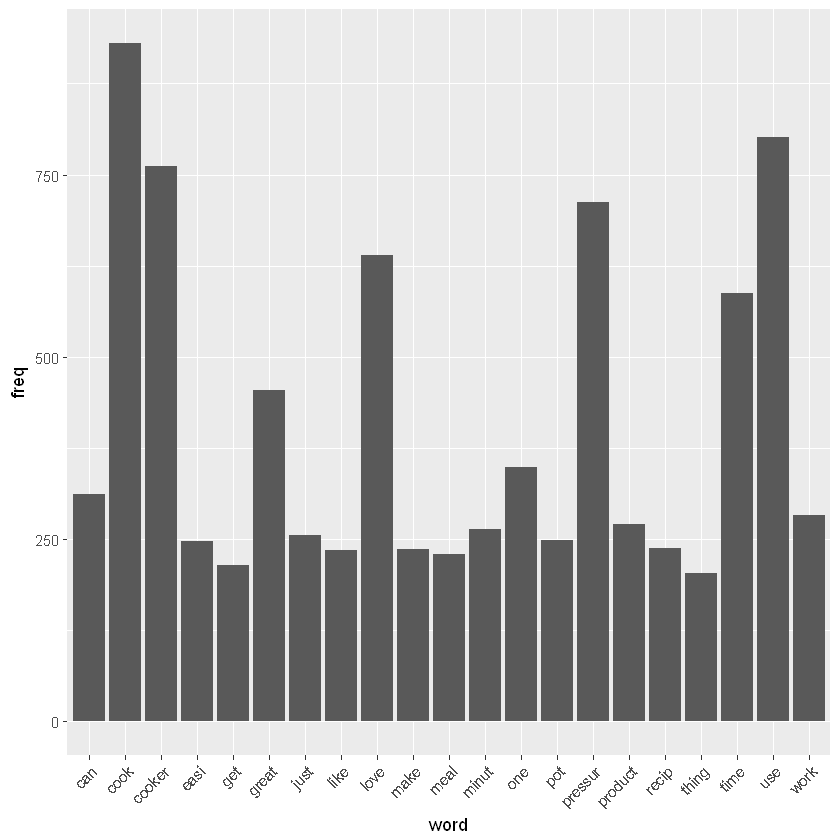

In [40]:
wf <- data.frame(word=names(freq_hi), freq=freq_hi)
p <- ggplot(subset(wf, freq>200), aes(word, freq))
p <- p + geom_bar(stat="identity")
p <- p + theme(axis.text.x=element_text(angle=45, hjust=1))
p

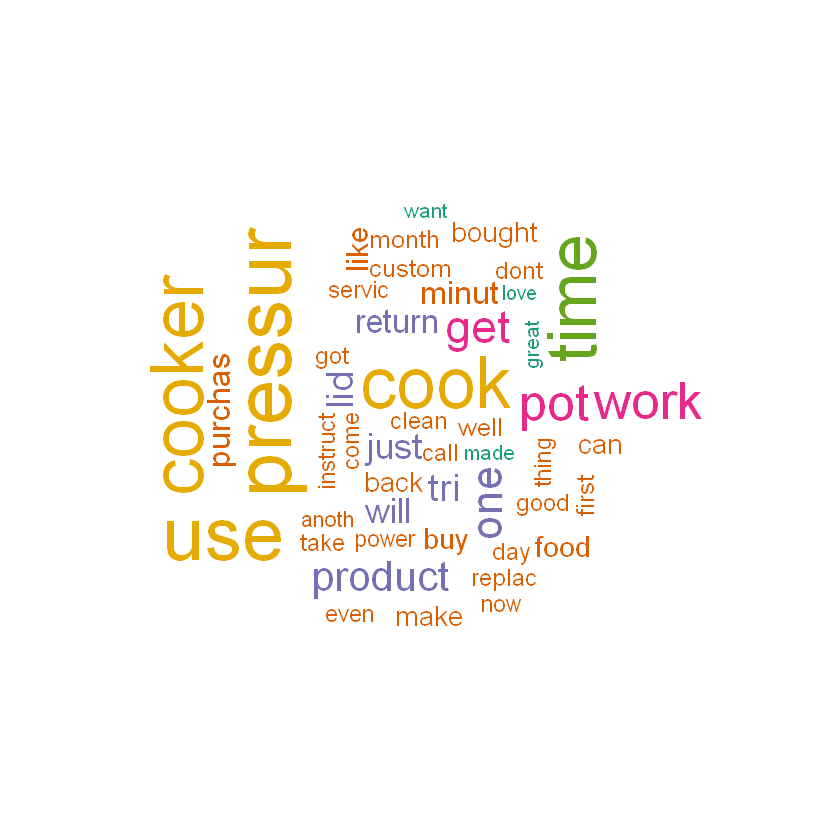

In [42]:
dtm_lowspar <- removeSparseTerms(dtm_low, 0.9) # Prepare the data (max 90% empty space)   
freq <- colSums(as.matrix(dtm_lowspar))    # Find word frequencies   
dark2 <- brewer.pal(6, "Dark2")   
wordcloud(names(freq), freq, max.words=100, rot.per=0.2, colors=dark2)

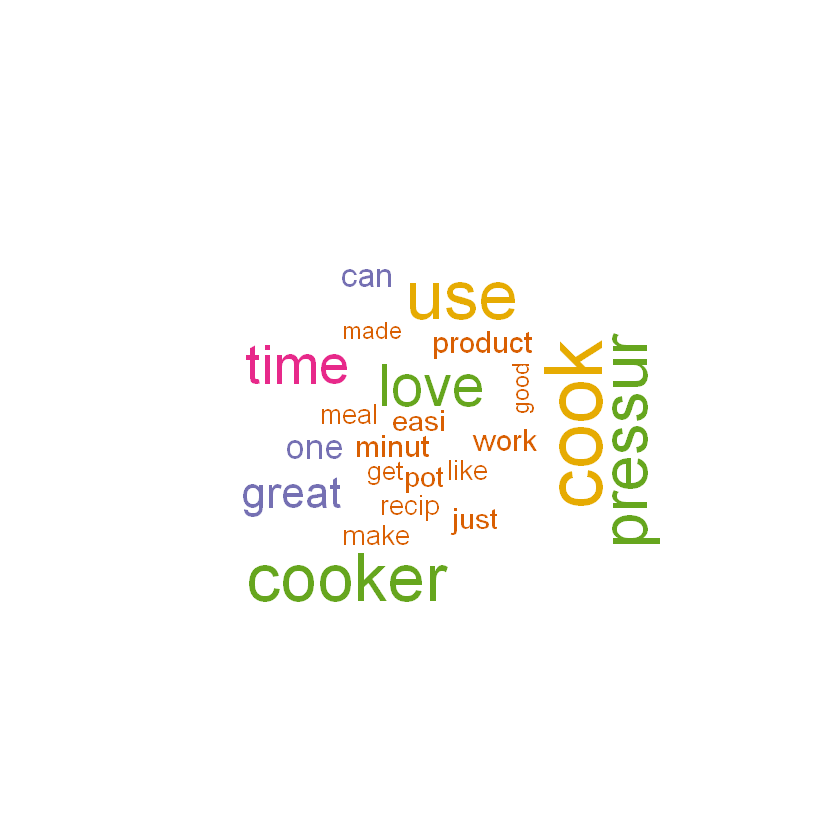

In [43]:
dtm_hispar <- removeSparseTerms(dtm_hi, 0.9) # Prepare the data (max 90% empty space)   
freq <- colSums(as.matrix(dtm_hispar))    # Find word frequencies   
dark2 <- brewer.pal(6, "Dark2")   
wordcloud(names(freq), freq, max.words=100, rot.per=0.2, colors=dark2) 

# **K-Means Clustering**
## -  Finds the euclidian distance between words and places them in clusters
## -  Attempts to minimize the sum of the squared distances within each cluster
## -  Attempts to maximize the sum of the squared distances between each cluster

***

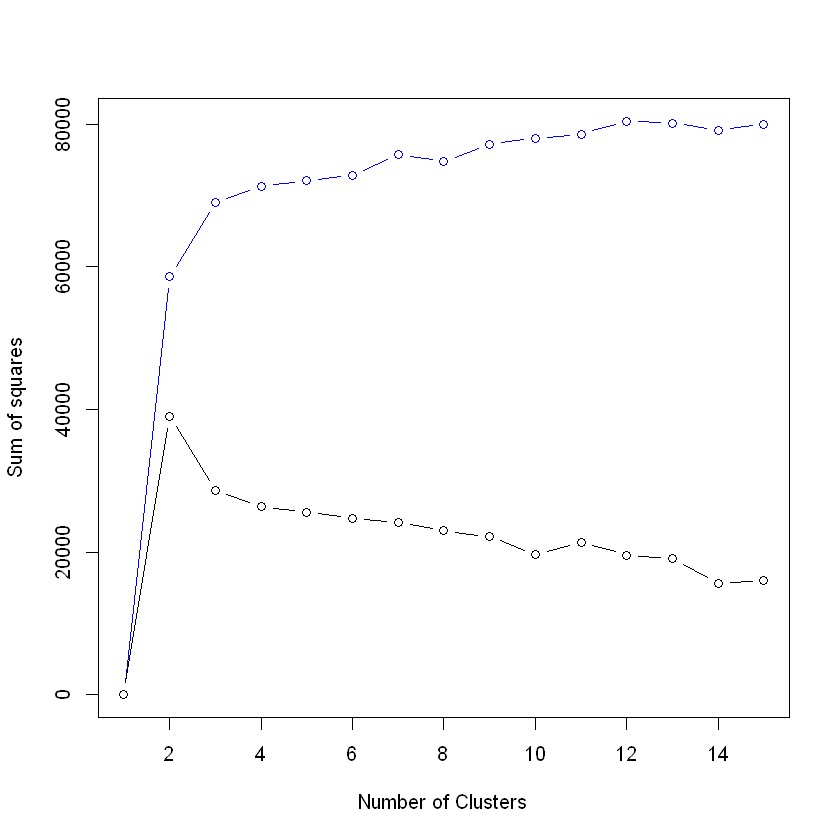

In [45]:
#Elbow method
#Plot the total distance between clusters and within clusters by k value
d <- dist(t(dtm_lowspar), method="euclidian")  
bss<-integer(length(2:15))
for (i in 2:15) bss[i] <- kmeans(d,centers=i)$betweenss
plot(1:15, bss, type="b", xlab="Number of Clusters",
     ylab="Sum of squares", col="blue") 
wss<-integer(length(2:15))
for (i in 2:15) wss[i] <- kmeans(d,centers=i)$tot.withinss
lines(1:15, wss, type="b" ) 

In [46]:
kfit <- kmeans(d, 3)   
kfit


K-means clustering with 3 clusters of sizes 34, 6, 8

Cluster means:
    bought     come     cook   cooker      day     dont     food      get
1 17.11930 16.52158 37.37275 34.76289 16.89484 17.73955 21.70846 24.32307
2 35.87929 35.25760 31.03426 29.32435 36.32543 36.21253 35.67325 34.99996
3 23.78522 23.80942 37.75159 35.94942 24.28580 24.75540 23.65975 23.99569
      good      got    great      lid     love     made    month      now
1 16.38898 17.47014 16.06229 25.25130 15.66637 16.34382 17.50962 15.88325
2 35.05324 35.87829 35.69084 37.98482 36.31047 35.98958 36.94229 35.26829
3 23.27876 24.04179 23.53546 25.53237 23.47846 23.96797 24.49441 23.10027
       one      pot  pressur      tri      use     want     well     will
1 24.56328 34.36894 39.33696 22.16610 33.25032 15.89384 17.21830 19.67058
2 36.04528 33.66238 31.19122 35.60023 31.48758 35.70729 34.93241 35.02232
3 25.04417 36.62297 39.04747 23.23227 34.49520 23.39996 23.74104 25.03830
      work      buy    anoth     call    cl

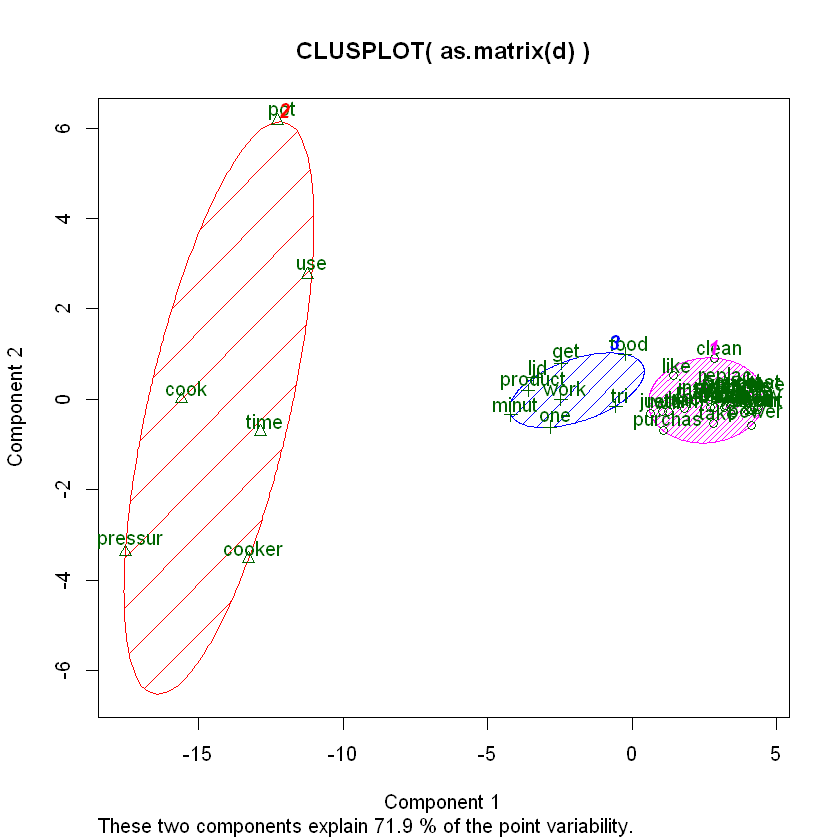

In [47]:
library(cluster)
clusplot(as.matrix(d), kfit$cluster, color=T, shade=T, labels=2, lines=0)  


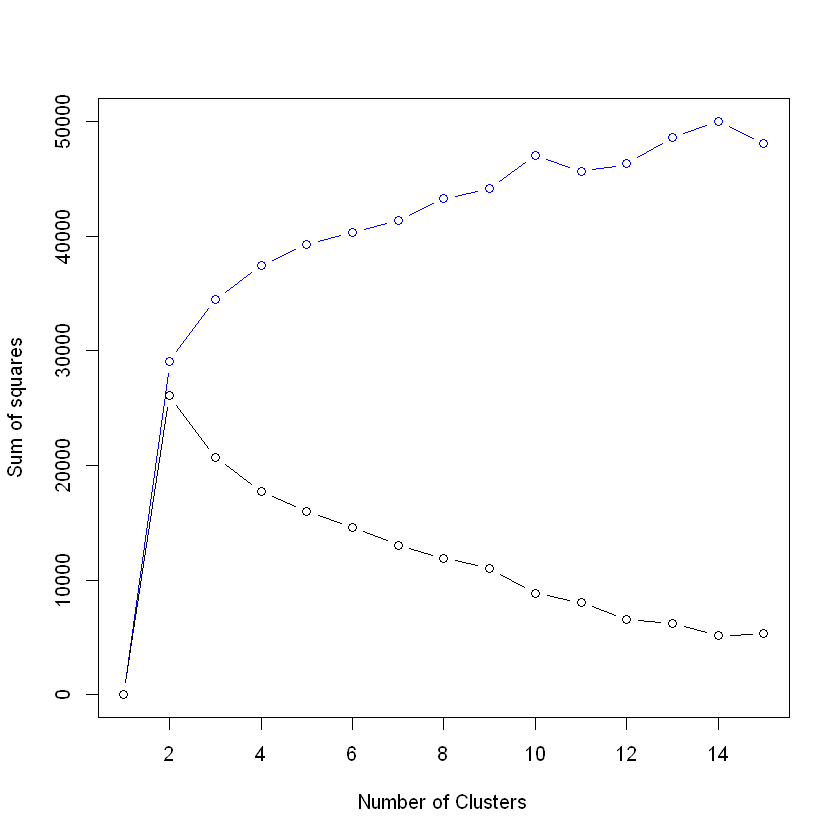

In [48]:
#Elbow method
#Plot the total distance between clusters and within clusters by k value
d <- dist(t(dtm_hispar), method="euclidian") 
bss<-integer(length(2:15))
for (i in 2:15) bss[i] <- kmeans(d,centers=i)$betweenss
plot(1:15, bss, type="b", xlab="Number of Clusters",
     ylab="Sum of squares", col="blue") 
wss<-integer(length(2:15))
for (i in 2:15) wss[i] <- kmeans(d,centers=i)$tot.withinss
lines(1:15, wss, type="b" ) 

In [49]:
kfit <- kmeans(d, 3)   
kfit

K-means clustering with 3 clusters of sizes 3, 3, 16

Cluster means:
       can     cook   cooker     easi      get     good     just     like
1 37.21310 44.45794 46.41517 38.44047 34.79923 38.03314 37.66788 38.22014
2 43.79886 28.11685 25.14760 51.74076 47.04507 51.69108 48.61464 49.29072
3 28.58499 51.88195 46.95206 24.68740 23.30038 22.92724 25.63882 24.09134
      love     made     make    minut      one      pot  pressur  product
1 42.72112 36.96678 36.06185 26.87130 38.04780 35.81260 44.87661 39.53361
2 53.41025 50.89799 48.04895 49.28443 49.11622 45.83777 23.01365 52.48645
3 31.58287 22.83799 22.96264 35.01511 27.72805 27.61622 50.87550 25.15090
     recip     time      use     work    great     meal
1 37.05458 24.45830 26.75319 38.49818 40.53662 38.73979
2 49.57294 42.87389 43.59139 51.60611 52.99600 52.29688
3 25.09593 38.39715 40.65278 24.20727 27.12429 24.14164

Clustering vector:
    can    cook  cooker    easi     get    good    just    like    love    made 
      3       

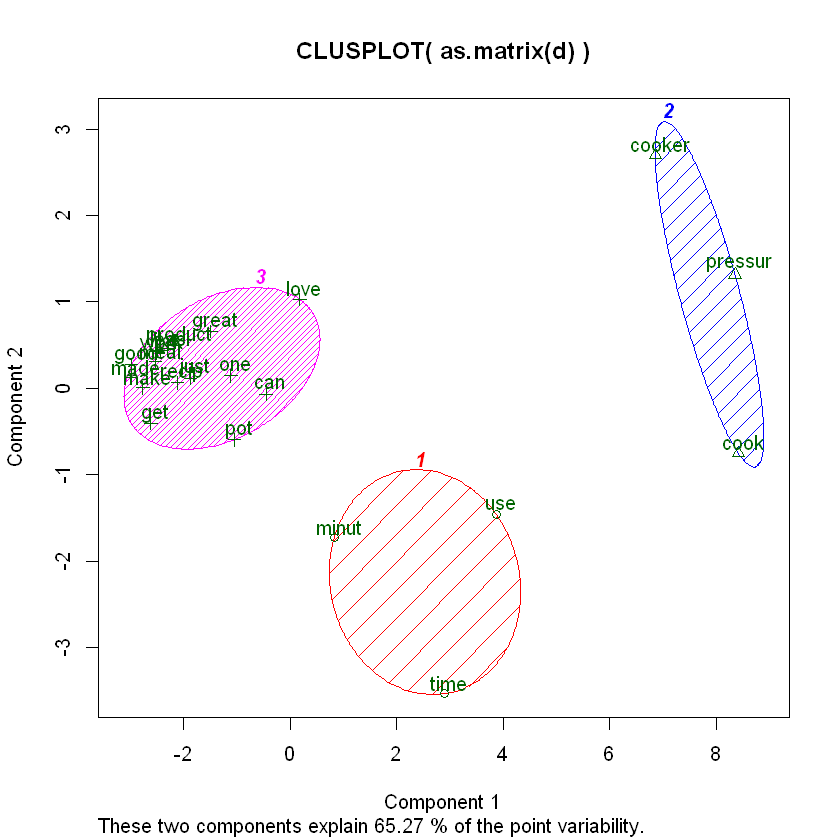

In [50]:
clusplot(as.matrix(d), kfit$cluster, color=T, shade=T, labels=2, lines=0)  

# **Dendogram** - A heirarchical tree diagram showing similar groups

***

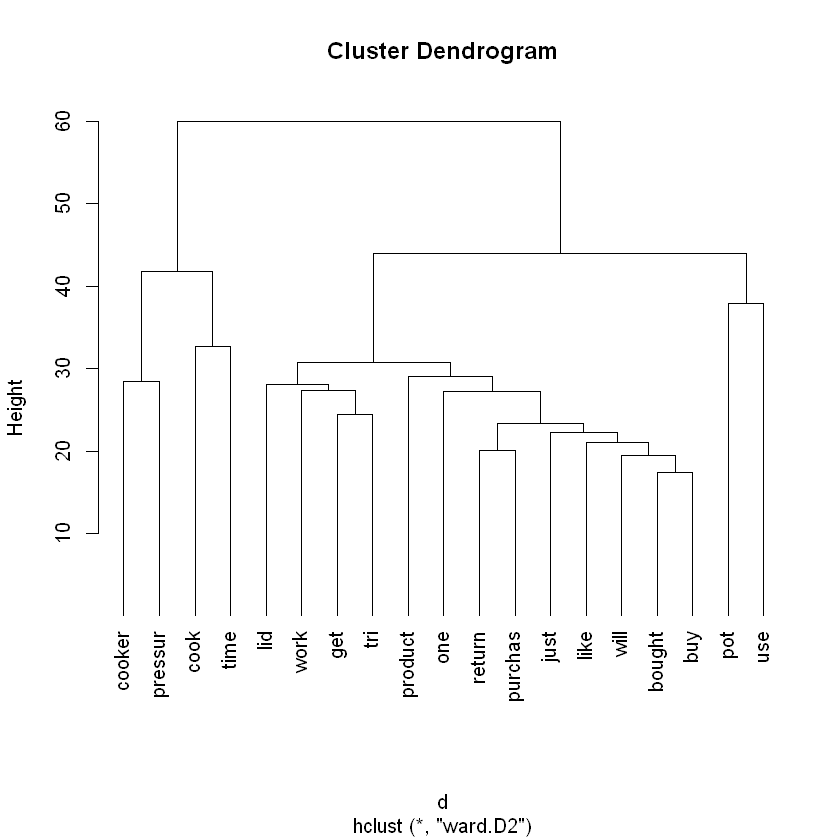

In [51]:
dtm_lows <- removeSparseTerms(dtm_low, 0.85)
d <- dist(t(dtm_lows), method="euclidian")
fit <- hclust(d=d, method="ward.D2")
plot(fit, hang=-1)

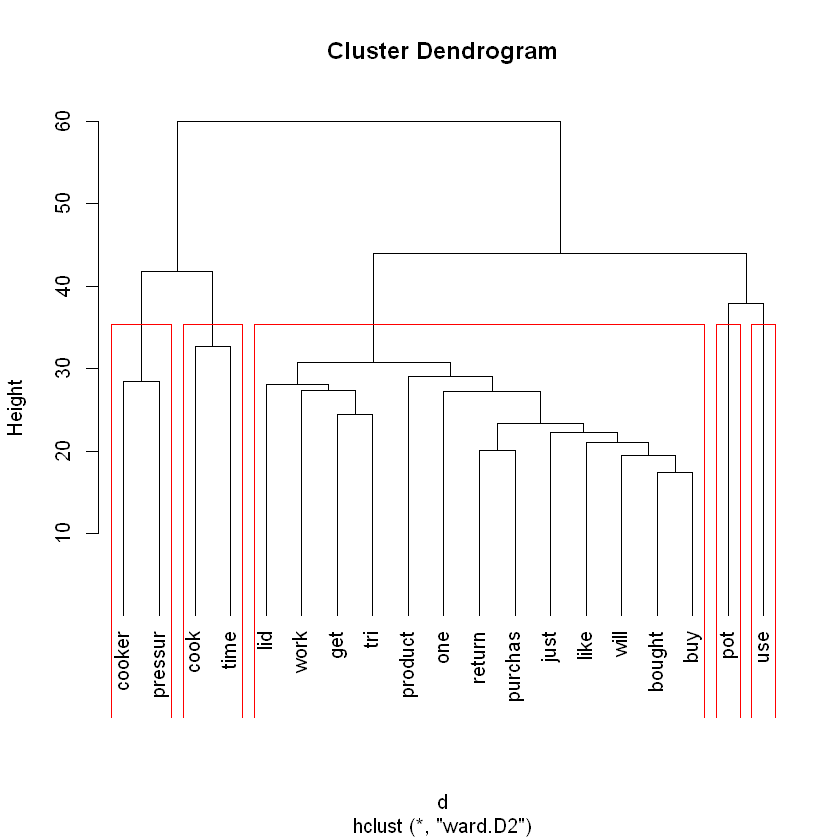

In [52]:
plot.new()
plot(fit, hang=-1)
groups <- cutree(fit, k=5)
rect.hclust(fit, k=5, border="red")

# **What else?**
## -  bigrams ("pressure cooker")
## -  trigrams ("sixty day warranty")
## - word2vec?
## - sentiment dictionaries with predefined "good" and "bad" words
***

# <font color=blue>Tom Foster<font>
## <font color=blue>_tfoster306@gmail.com_<font>